In [ ]:
%pip install mysql.connector

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.9/11.9 MB 57.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for mysql.connector: filename=mysql_connector-2.2.9-cp39-cp39-linux_x86_64.whl size=247964 sha256=f916aace41ea66c8977f987b572f9dad7fcd7e151b8e4a7e4ffa991417117142
  Stored in directory: /root/.cache/pip/wheels/7b/14/39/5aad423666e827dfe9a1fbcd111ac17171e7c9865d570780ce
Successfully built mysql.connector


In [ ]:
import pandas as pd
import mysql.connector
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split
import numpy as np

In [ ]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cpu')

In [ ]:
cnx = mysql.connector.connect(user='forecast1', password='',
                              host='',
                              database='forecast1')
cursor = cnx.cursor()

query = 'SELECT * FROM complete where `Код поста` = 76289;'
cursor.execute(query)
data = cursor.fetchall()

df = pd.DataFrame(data, columns=cursor.column_names)

cursor.close()
cnx.close()
df

,Object ID,Код поста,Код параметра,Дата - время,Уровень воды,Описание,Температура воздуха,Атмосферное давление,Скорость ветра,Толщина снежного покрова,Количество осадков
0,53442,76289,1,1997-04-01,46,,0,740,4,5,3
1,53443,76289,1,1997-04-02,78,,3,750,6,5,0
2,53444,76289,1,1997-04-03,126,,5,736,6,0,0
3,53445,76289,1,1997-04-04,161,,6,749,3,0,0
4,53446,76289,1,1997-04-05,219,,8,749,3,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6690,60132,76289,1,2020-10-26,-80,,1,750,5,3,0
6691,60133,76289,1,2020-10-27,-58,,2,764,5,11,0
6692,60134,76289,1,2020-10-28,-16,,1,767,3,0,0
6693,60135,76289,1,2020-10-29,10,,5,767,3,0,0


In [ ]:
clear_df= df.drop(columns=["Object ID", "Описание", "Дата - время", "Код поста", "Код параметра"]).astype(np.float32)
num_days = 2
num_days_out = 1
num_matrices = clear_df.shape[0] -num_days
inputs = torch.zeros((num_matrices, num_days, len(clear_df.columns)))

for i in range(num_matrices):
  inputs[i] = torch.tensor(clear_df.iloc[i:i+num_days].values)
targets = []

for i in range(len(inputs) - num_days):
  targets.append(np.array(inputs[i + num_days, :num_days_out, 0]))
inputs = inputs[:-num_days]
targets = torch.tensor(targets)
dataset = TensorDataset(inputs, targets)
print(inputs, targets)
train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size
print(train_size, val_size, test_size)
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

batch_size = 100
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, drop_last=True)

tensor([[[ 46.,   0., 740.,   4.,   5.,   3.],
         [ 78.,   3., 750.,   6.,   5.,   0.]],

        [[ 78.,   3., 750.,   6.,   5.,   0.],
         [126.,   5., 736.,   6.,   0.,   0.]],

        [[126.,   5., 736.,   6.,   0.,   0.],
         [161.,   6., 749.,   3.,   0.,   0.]],

        ...,

        [[-79.,   4., 743.,   3.,  48.,   7.],
         [-78.,   8., 749.,   1.,   0.,  11.]],

        [[-78.,   8., 749.,   1.,   0.,  11.],
         [-80.,   1., 750.,   5.,   3.,   0.]],

        [[-80.,   1., 750.,   5.,   3.,   0.],
         [-58.,   2., 764.,   5.,  11.,   0.]]]) tensor([[126.],
        [161.],
        [219.],
        ...,
        [-80.],
        [-58.],
        [-16.]])
4683 1338 670


<ipython-input-5-c827e3edaa3e>:14: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  targets = torch.tensor(targets)


In [ ]:
class NeuralNet(nn.Module):
  def __init__(self, input_size, hidden_size):
      super(NeuralNet, self).__init__()
      self.fc1 = nn.Linear(input_size, hidden_size)
      self.relu = nn.ReLU()
      self.fc2 = nn.Linear(hidden_size * num_days, num_days_out)

  def forward(self, x):
      inputs = (x - torch.min(x)) / (torch.max(x) - torch.min(x))
      out = self.fc1(x)
      out = self.relu(out)
      out = out.view(batch_size, -1)
      out = self.fc2(out)
      return out

In [ ]:
def train(model, loader, loss_function, optimizer):
    model.train()

    epoch_loss = 0

    for row in loader:
        targets, inputs = row[1].to(DEVICE), row[0].to(DEVICE)

        outputs = model(inputs)
        loss = loss_function(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
    return epoch_loss / len(loader)

In [ ]:
def test(model, loader, loss_function):
    with torch.no_grad():
        model.eval()
        total_loss = 0.0
        total_good_ans = 0
        for i, row in enumerate(loader):
            targets, inputs = row[1].to(DEVICE), row[0].to(DEVICE)
            outputs = model(inputs)

            tensor = torch.absolute(targets - outputs)
            row_means = tensor.mean(axis=1)
            selected_rows = tensor[row_means <= 15, :]
            total_good_ans += selected_rows.shape[0]

            loss = loss_function(outputs, targets)
            total_loss += loss.item()
        return total_loss / len(loader), total_good_ans / (len(loader) * batch_size)

In [ ]:
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

In [ ]:
input_size = test_dataset[0][0].shape[1]
hidden_size = 32
model = NeuralNet(input_size, hidden_size).to(DEVICE)

loss_function = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.2)

# patience = 60
# factor = 0.5
# scheduler = ReduceLROnPlateau(optimizer, patience=patience, factor=factor)

step_size = 100
gamma = 0.65
scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)

# T_0 = 300
# T_mult = 2
# eta_min = 0
# scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=T_0, T_mult=T_mult, eta_min=eta_min)


In [ ]:
torch.set_grad_enabled(True)

num_epochs = 1200
train_losses = []
val_losses = []
for epoch in range(num_epochs):
    train_loss = train(model, loader=train_loader, loss_function=loss_function, optimizer=optimizer)
    val_loss, accuracy= test(model=model, loader=val_loader, loss_function=loss_function)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    scheduler.step()
    if epoch % 30 == 0:
      print(f'Epoch {epoch}')
      print(f'Train Loss {train_loss:.6f} Val Loss {val_loss:.6f}, Val Accuracy {accuracy:.6f}')
      print('---')

test_loss, test_accuracy = test(model=model, loader=test_loader, loss_function=loss_function)
print(f'Test Loss {test_loss:.6f}, Test Accuracy {test_accuracy:.6f}')

Epoch 0
Train Loss 112.593835 Val Loss 59.252959, Val Accuracy 0.152308
---
Epoch 30
Train Loss 20.580671 Val Loss 12.534087, Val Accuracy 0.748462
---
Epoch 60
Train Loss 17.280631 Val Loss 18.779507, Val Accuracy 0.384615
---
Epoch 90
Train Loss 18.220792 Val Loss 22.553517, Val Accuracy 0.426154
---
Epoch 120
Train Loss 12.873174 Val Loss 16.486626, Val Accuracy 0.630769
---
Epoch 150
Train Loss 12.939448 Val Loss 18.023876, Val Accuracy 0.636923
---
Epoch 180
Train Loss 11.630026 Val Loss 12.556206, Val Accuracy 0.713077
---
Epoch 210
Train Loss 10.012061 Val Loss 9.713964, Val Accuracy 0.821538
---
Epoch 240
Train Loss 10.184920 Val Loss 9.357933, Val Accuracy 0.831538
---
Epoch 270
Train Loss 13.026902 Val Loss 13.161567, Val Accuracy 0.730000
---
Epoch 300
Train Loss 9.972363 Val Loss 9.546590, Val Accuracy 0.824615
---
Epoch 330
Train Loss 9.716689 Val Loss 9.210588, Val Accuracy 0.829231
---
Epoch 360
Train Loss 12.351126 Val Loss 10.859881, Val Accuracy 0.786923
---
Epoch 390

In [ ]:
import matplotlib.pyplot as plt

<function matplotlib.pyplot.show(close=None, block=None)>

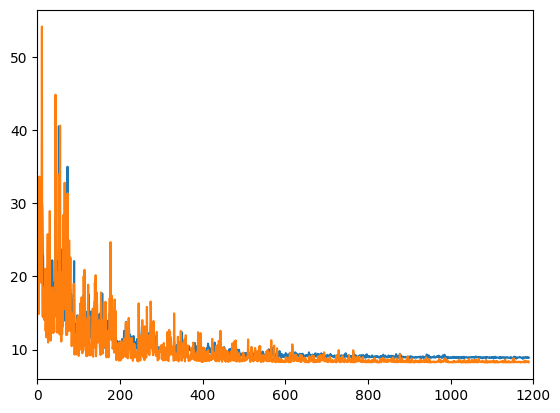

In [ ]:
fig, ax = plt.subplots()
ax.set_xlim(0, num_epochs)
skip_epochs =10
plt.plot(range(len(train_losses[skip_epochs:])), train_losses[skip_epochs:])
plt.plot(range(len(val_losses[skip_epochs:])), val_losses[skip_epochs:])
plt.show

In [ ]:
def print_result(model, loader):
    for i, row in enumerate(loader):
        targets, inputs = row[1].to(DEVICE), row[0].to(DEVICE)
        outputs = model.forward(inputs)
        for i in range(targets.shape[0]):
          print(f"Input waterlevels {inputs[i, :, :1].detach().numpy().reshape(1, -1)}")
          print(f"Target {targets[i].detach().numpy()}, Output {outputs[i].detach().numpy()}")

In [ ]:
model.eval()
print_result(model=model, loader=test_loader)

Input waterlevels [[669. 624.]]
Target [565.], Output [594.83405]
Input waterlevels [[-20. -14.]]
Target [-12.], Output [-10.590073]
Input waterlevels [[410. 392.]]
Target [354.], Output [378.5545]
Input waterlevels [[172. 228.]]
Target [280.], Output [255.64168]
Input waterlevels [[10. 19.]]
Target [13.], Output [22.292526]
Input waterlevels [[684. 663.]]
Target [657.], Output [641.70306]
Input waterlevels [[-76. -76.]]
Target [-82.], Output [-75.68042]
Input waterlevels [[511. 488.]]
Target [446.], Output [469.7293]
Input waterlevels [[1. 6.]]
Target [3.], Output [6.952057]
Input waterlevels [[-90. -90.]]
Target [-88.], Output [-88.72592]
Input waterlevels [[-6. -6.]]
Target [-6.], Output [-6.205719]
Input waterlevels [[-109. -109.]]
Target [-111.], Output [-108.706345]
Input waterlevels [[-121. -123.]]
Target [-123.], Output [-123.161194]
Input waterlevels [[7. 7.]]
Target [7.], Output [7.0327606]
Input waterlevels [[-121. -124.]]
Target [-124.], Output [-124.19284]
Input waterlevel